In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import shutil
from skimage import exposure

# tqdm'un pandas ile entegrasyonu için
tqdm.pandas()

# Orijinal olan veriler
DATASET_ROOT = "dataset/wood"
TRAIN_GOOD_PATH = os.path.join(DATASET_ROOT, "train", "good")
TEST_GOOD_PATH = os.path.join(DATASET_ROOT, "test", "good")
TEST_DEFECT_PATH = os.path.join(DATASET_ROOT, "test", "defect")

# preprocess yapıldıktan sonra kaydedeceğimiz yer
PREPROCESSED_ROOT = "dataset/wood_preprocessed_notebook"

print(f"Orijinal Dataset Kök Dizini: {DATASET_ROOT}")
print(f"Önişlenmiş Veri Kök Dizini: {PREPROCESSED_ROOT}")

Orijinal Dataset Kök Dizini: dataset/wood
Önişlenmiş Veri Kök Dizini: dataset/wood_preprocessed_notebook


In [3]:

def show_img(img, title=""):
    plt.figure(figsize=(8, 6))
    if img.ndim == 2:
        plt.imshow(img)
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

def imread_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Cannot read image: {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def imwrite_rgb(path, rgb):
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, bgr)

print("Yardımcı fonksiyonlar yüklendi.")


Yardımcı fonksiyonlar yüklendi.


In [4]:
# 1) Maske Üretimi — Otsu + Morfoloji + En Büyük Bileşen
def build_wood_mask(rgb, blur_ksize=5, morph_ksize=9):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    if blur_ksize and blur_ksize > 0:
        gray = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    # Otsu threshold
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Ahşabı beyaz (255) yapmak için uygun polariteyi seç
    def largest_area(mask):
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            return 0
        return max(cv2.contourArea(c) for c in cnts)

    area_normal = largest_area(th)
    area_invert = largest_area(255 - th)
    mask = th if area_normal >= area_invert else (255 - th)

    # Morfoloji: kapama (delikleri doldur), ardından açma (küçük gürültüyü kaldır)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_ksize, morph_ksize))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=1)

    # Sadece en büyük bağlı bileşeni (tahta) bırak
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = np.zeros_like(mask)
    if cnts:
        largest = max(cnts, key=cv2.contourArea)
        cv2.drawContours(out, [largest], -1, 255, thickness=-1)
    else:
        out = mask
    return out

def apply_mask(rgb, mask):
    mask_3 = np.dstack([mask] * 3) / 255.0
    return (rgb * mask_3).astype(np.uint8)

print("Maskeleme fonksiyonları hazır.")


Maskeleme fonksiyonları hazır.


In [5]:
# 2) Kontrast & Keskinleştirme & Yeniden Boyutlandırma
def enhance_contrast_clahe(rgb, clip_limit=2.0, tile_grid_size=(8, 8)):
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    L2 = clahe.apply(L)
    lab2 = cv2.merge([L2, A, B])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)

def unsharp_mask(rgb, radius=2, amount=1.2):
    sigma = max(radius, 0.1)
    blurred = cv2.GaussianBlur(rgb, (0, 0), sigmaX=sigma, sigmaY=sigma)
    return cv2.addWeighted(rgb, 1 + amount, blurred, -amount, 0)

def resize_rgb(rgb, target_size=None, keep_aspect=True):
    if target_size is None:
        return rgb
    H, W = rgb.shape[:2]
    tw, th = target_size  # (width, height)
    if keep_aspect:
        scale = min(tw / W, th / H)
        new_w, new_h = int(W * scale), int(H * scale)
        resized = cv2.resize(rgb, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
        canvas = np.zeros((th, tw, 3), dtype=np.uint8)
        y0 = (th - new_h) // 2
        x0 = (tw - new_w) // 2
        canvas[y0:y0 + new_h, x0:x0 + new_w] = resized
        return canvas
    else:
        return cv2.resize(rgb, (tw, th), interpolation=cv2.INTER_LANCZOS4)

print("İyileştirme & yeniden boyutlandırma fonksiyonları hazır.")


İyileştirme & yeniden boyutlandırma fonksiyonları hazır.


In [6]:
# 3) Tam Pipeline
def preprocess_wood_image(
    rgb,
    do_mask=True,
    contrast=True,
    sharpen=True,
    resize_to=(1024, 1024),  # None yaparsanız boyut korunur
    save_mask_path=None,
    clahe_clip=2.0,
    clahe_tile=(8,8),
    sharp_radius=2,
    sharp_amount=1.2,
):
    out = rgb.copy()
    if do_mask:
        mask = build_wood_mask(out, blur_ksize=5, morph_ksize=9)
        if save_mask_path:
            os.makedirs(os.path.dirname(save_mask_path), exist_ok=True)
            cv2.imwrite(save_mask_path, mask)
        out = apply_mask(out, mask)

    if contrast:
        out = enhance_contrast_clahe(out, clip_limit=clahe_clip, tile_grid_size=clahe_tile)

    if sharpen:
        out = unsharp_mask(out, radius=sharp_radius, amount=sharp_amount)

    if resize_to is not None:
        out = resize_rgb(out, target_size=resize_to, keep_aspect=True)

    return out

print("Pipeline fonksiyonu hazır.")


Pipeline fonksiyonu hazır.


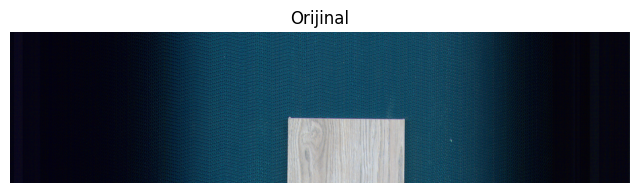

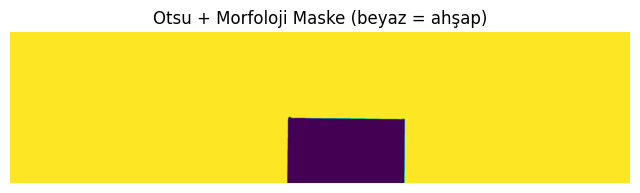

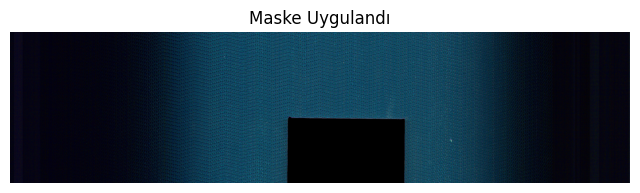

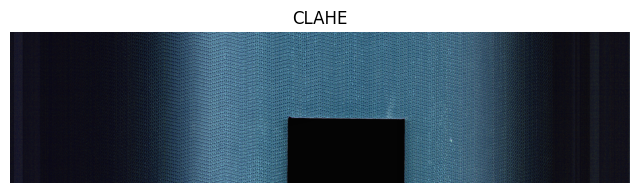

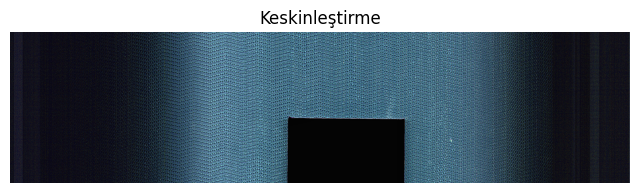

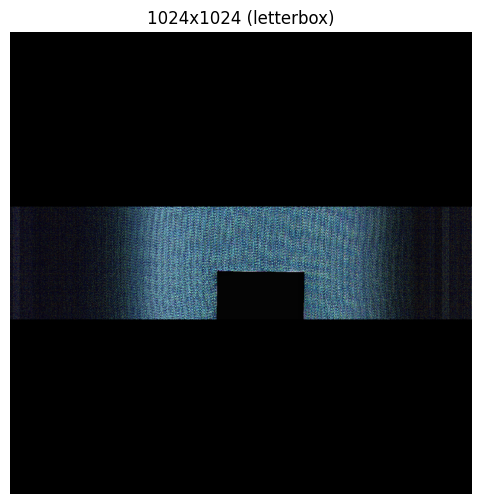

In [7]:
# 4) Tek Görsel Üzerinde Örnek Uygulama
SAMPLE_PATH = "dataset/wood/train/good/Basler_r2L4096-14gc__40653549__20251009_075252367_0014.bmp"

try:
    rgb = imread_rgb(SAMPLE_PATH)
    show_img(rgb, "Orijinal")

    mask = build_wood_mask(rgb)
    show_img(mask, "Otsu + Morfoloji Maske (beyaz = ahşap)")

    masked = apply_mask(rgb, mask)
    show_img(masked, "Maske Uygulandı")

    clahe_img = enhance_contrast_clahe(masked)
    show_img(clahe_img, "CLAHE")

    sharp_img = unsharp_mask(clahe_img)
    show_img(sharp_img, "Keskinleştirme")

    resized_img = resize_rgb(sharp_img, target_size=(1024, 1024), keep_aspect=True)
    show_img(resized_img, "1024x1024 (letterbox)")
except FileNotFoundError as e:
    print(e)
    print("Lütfen 'SAMPLE_PATH' değişkenini güncelleyin ve hücreyi tekrar çalıştırın.")


In [8]:
# 5) Tüm Dataset'i İşleme ve Kaydetme
def process_dataset(
    src_root,
    dst_root,
    resize_to=(1024, 1024),
    save_masks=True,
    extensions=(".bmp", ".png", ".jpg", ".jpeg"),
    clahe_clip=2.0,
    clahe_tile=(8,8),
    sharp_radius=2,
    sharp_amount=1.2,
):
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    subdirs = [
        ("train/good", "train/good"),
        ("test/good", "test/good"),
        ("test/defect", "test/defect"),
    ]
    counts = {}

    for src_rel, dst_rel in subdirs:
        src_dir = src_root / src_rel
        dst_dir = dst_root / dst_rel
        mask_dir = dst_root / (dst_rel + "_masks")

        os.makedirs(dst_dir, exist_ok=True)
        if save_masks:
            os.makedirs(mask_dir, exist_ok=True)

        n = 0
        if src_dir.exists():
            for name in sorted(os.listdir(src_dir)):
                if not name.lower().endswith(extensions):
                    continue
                src_path = str(src_dir / name)
                rgb = imread_rgb(src_path)
                mask_path = str(mask_dir / (Path(name).stem + "_mask.png")) if save_masks else None
                processed = preprocess_wood_image(
                    rgb,
                    do_mask=True,
                    contrast=True,
                    sharpen=True,
                    resize_to=resize_to,
                    save_mask_path=mask_path,
                    clahe_clip=clahe_clip,
                    clahe_tile=clahe_tile,
                    sharp_radius=sharp_radius,
                    sharp_amount=sharp_amount,
                )
                out_path = str(dst_dir / name)
                imwrite_rgb(out_path, processed)
                n += 1
        counts[dst_rel] = n
    return counts

print("Dataset işleme fonksiyonu hazır.")


Dataset işleme fonksiyonu hazır.
